In [253]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

#Transformação de dados#

##Base Desfechos##

Leitura da base

In [41]:
df=pd.read_csv('HSL_Desfechos_2.csv',sep='|')

Como o ID da clínica e do atendimento não tem relação nenhuma com as doenças, foram descartadas

In [42]:
df.head()

,id_paciente,id_atendimento,dt_atendimento,de_tipo_atendimento,id_clinica,de_clinica,dt_desfecho,de_desfecho
0,3487791F44C34B421C932DC8616A8437,33277D918111011E48FABCD6FC09012B,2020-07-08,Pronto Atendimento,6,Ortopedia,2020-07-08,Alta médica melhorado
1,3487791F44C34B421C932DC8616A8437,2DF164AD7E51B0A2F52B6DB58F904A22,2020-05-08,Externo,20,Procedimentos,2020-05-08,Alta Administrativa
2,3487791F44C34B421C932DC8616A8437,11676CFEEF6A4CDD49B0A74D3F3A85EC,2020-05-25,Externo,20,Procedimentos,2020-05-25,Alta Administrativa
3,0AD1FFA4419472256666A3445414F1F9,70A834FEFF3562FCBA3888D592DA2609,2020-03-16,Externo,20,Procedimentos,2020-03-16,Alta Administrativa
4,3487791F44C34B421C932DC8616A8437,A3F017D035922D728E06B744511A6797,2020-05-11,Pronto Atendimento,42,CL Médica Síndromes Virais,2020-05-11,Alta médica melhorado


In [43]:
df['de_desfecho'].unique()

array(['Alta médica melhorado', 'Alta Administrativa', nan,
       'Alta a pedido', 'Desistência do atendimento',
       'Alta médica Inalterado',
       'Óbito após 48hs de internação sem necrópsia',
       'Alta médica curado',
       'Transferência Inter-Hospitalar Externa - Serviço de Ambulância',
       'Alta por abandono',
       'Transferência Inter-Hospitalar Externa - Transporte Próprio',
       'Assistência Domiciliar',
       'Óbito nas primeiras 48hs de internação sem necrópsia não agônico'],
      dtype=object)

In [44]:
desfechos = df.drop(['id_clinica','id_atendimento'],axis=1)

Para facilitar iremos considerar apenas dois desfechos, óbito e alta. Para isso, descartamos os demais tipos

In [45]:
desfechos=desfechos[desfechos['de_desfecho']!='Transferência Inter-Hospitalar Externa - Serviço de Ambulância']
desfechos=desfechos[desfechos['de_desfecho']!='Transferência Inter-Hospitalar Externa - Transporte Próprio']
desfechos=desfechos[desfechos['de_desfecho']!='Desistência do atendimento']
desfechos=desfechos[desfechos['de_desfecho']!='Assistência Domiciliar']
desfechos=desfechos[desfechos['de_desfecho']!='Alta por abandono']
desfechos=desfechos[desfechos['de_desfecho']!='Alta a pedido']

Visualização dos desfechos restantes

In [46]:
desfechos['de_desfecho'].astype('category').cat.categories

Index(['Alta Administrativa', 'Alta médica Inalterado', 'Alta médica curado',
       'Alta médica melhorado', 'Óbito após 48hs de internação sem necrópsia',
       'Óbito nas primeiras 48hs de internação sem necrópsia não agônico'],
      dtype='object')

Junção dos tipos de óbito em um único tipo

In [47]:
o1 = 'Óbito após 48hs de internação sem necrópsia'
o2 = 'Óbito nas primeiras 48hs de internação sem necrópsia não agônico'
t1=desfechos['de_desfecho']==o1
t2=desfechos['de_desfecho']==o2
d1=desfechos[t1|t2]
d1['de_desfecho']='O'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Junção dos tipos de alta em um único tipo

In [48]:
o1 = 'Óbito após 48hs de internação sem necrópsia'
o2 = 'Óbito nas primeiras 48hs de internação sem necrópsia não agônico'
t1=desfechos['de_desfecho']!=o1
t2=desfechos['de_desfecho']!=o2
d2=desfechos[t1&t2]
d2['de_desfecho']='A'
desfechos=pd.concat([d1,d2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Temos então apenas dois tipos de desfechos

In [49]:
desfechos['de_desfecho'].astype('category').cat.categories

Index(['A', 'O'], dtype='object')

Transformação das datas dos atendimentos em dias contando do início do ano

In [50]:
lista=[]
for data in desfechos.iloc:
    split = data[1].split('-')
    dias = (int(split[1])-1)*30+int(split[2])
    lista.append(dias)
desfechos['dt_atendimento']=lista

Removendo missing values

In [51]:
desfechos = desfechos[desfechos['dt_desfecho']==desfechos['dt_desfecho']]

Transformação das datas dos desfechos em dias contando do início do ano

In [52]:
lista=[]
for data in desfechos.iloc:
    split = data[4].split('-')
    dias = (int(split[1])-1)*30+int(split[2])
    lista.append(dias)
desfechos['dt_desfecho']=lista

Criação de uma coluna para o número de total de atendimentos, inicialmente = 0

In [53]:
desfechos['n_atendimentos']=0

Criação de uma lista com o ID de cada paciente

In [54]:
desfechos_juntos = desfechos.drop_duplicates('id_paciente')
unique=desfechos_juntos['id_paciente']

Código para juntar as informações de todos os atendimentos de um mesmo ID em uma mesma linha e calcular o número total de atendimentos

In [55]:
dic={}
for i,id in enumerate(unique):
    dic[id]=i
dt_atendimento = ['']*len(unique)
total_atendimento = [0]*len(unique)
de_tipo_atendimento = ['']*len(unique)
de_clinica = ['']*len(unique)
dt_desfecho = ['']*len(unique)
de_desfecho = ['']*len(unique)
for data in desfechos.iloc:
    if data[0] in dic:
        total_atendimento[dic[data[0]]] += 1
        if dt_atendimento[dic[data[0]]] == '':
            dt_atendimento[dic[data[0]]]+=str(data[1])
            de_tipo_atendimento[dic[data[0]]]+=str(data[2])
            de_clinica[dic[data[0]]]+=str(data[3])
            dt_desfecho[dic[data[0]]]+=str(data[4])
            de_desfecho[dic[data[0]]]+=str(data[5])
        else:
            dt_atendimento[dic[data[0]]]+=','+str(data[1])
            de_tipo_atendimento[dic[data[0]]]+=','+str(data[2])
            de_clinica[dic[data[0]]]+=','+str(data[3])
            dt_desfecho[dic[data[0]]]+=','+str(data[4])
            de_desfecho[dic[data[0]]]+=','+str(data[5])
desfechos_juntos.iloc[:,-1]=total_atendimento
desfechos_juntos.iloc[:,1]=dt_atendimento
desfechos_juntos.iloc[:,2]=de_tipo_atendimento
desfechos_juntos.iloc[:,3]=de_clinica
desfechos_juntos.iloc[:,4]=dt_desfecho
desfechos_juntos.iloc[:,5]=de_desfecho

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


visualização do novo dataframe

In [56]:
desfechos_juntos = desfechos_juntos.drop(columns=['de_clinica'])

In [57]:
desfechos_juntos.head()

,id_paciente,dt_atendimento,de_tipo_atendimento,dt_desfecho,de_desfecho,n_atendimentos
400,BA74194B979B086198794D1470107709,194,Internado,204,O,1
511,8D265EED52D2877EC2F75B60FEEC4065,90,Internado,99,O,1
1070,7B03A278AD0026D4E34D0D84453A3548,"103,70","Internado,Externo","131,70","O,A",2
1373,DE791245DF4FD631AD71B2B307F7835D,"121,121","Internado,Pronto Atendimento","132,121","O,A",2
1803,44DA670729D76F0264E6066E2E42CF45,"80,80","Internado,Pronto Atendimento","142,82","O,A",2


Criação de uma coluna para o tempo total que que um ID foi atendido

In [58]:
tempo_atendimento = []
for data in desfechos_juntos.iloc:
    #print(data[1].split(','))
    total = 0
    for number1,number2 in zip(data[1].split(','),data[3].split(',')):
        total += int(number2) - int(number1) + 1
    tempo_atendimento.append(total)
desfechos_juntos['t_atendimento'] = tempo_atendimento

Com essa informação da duração total, os dias em que os atendimentos foram iniciados e os dias dos desfechos não são mais importantes

In [59]:
desfechos_juntos=desfechos_juntos.drop(columns=['dt_atendimento','dt_desfecho'])

In [60]:
desfechos_juntos

,id_paciente,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento
400,BA74194B979B086198794D1470107709,Internado,O,1,11
511,8D265EED52D2877EC2F75B60FEEC4065,Internado,O,1,10
1070,7B03A278AD0026D4E34D0D84453A3548,"Internado,Externo","O,A",2,30
1373,DE791245DF4FD631AD71B2B307F7835D,"Internado,Pronto Atendimento","O,A",2,13
1803,44DA670729D76F0264E6066E2E42CF45,"Internado,Pronto Atendimento","O,A",2,66
...,...,...,...,...,...
16939,A29ADDE51D11887EABFF9CC70E5F9A72,Pronto Atendimento,A,1,1
16940,50061499481B4B35DB108EB436A05500,"Externo,Externo","A,A",2,2
16942,74CC17F4F6DDAB860A70F7CCC2F8CF82,"Ambulatorial,Ambulatorial,Ambulatorial,Ambulat...","A,A,A,A,A",5,5
16947,1F382C34C14A2CC6DDD05825801EF68E,"Pronto Atendimento,Pronto Atendimento,Pronto A...","A,A,A,A,A,A",6,6


Junção das sequências de alta e óbito em um único desfecho

In [61]:
de_desfecho = []
for data in desfechos_juntos.iloc:
    app = False
    for desfecho in data[2].split(','):
        if desfecho == 'O':
            app = True
            de_desfecho.append('O')
            break
    if not app:
        de_desfecho.append('A')
desfechos_juntos['de_desfecho'] = de_desfecho

Junção dos tipos de atendimento considerando o pior caso

In [62]:
de_tipo_atendimento = []
for data in desfechos_juntos.iloc:
    p = 4
    for desfecho in data[1].split(','):
        if desfecho == 'Internado':
            tipo = desfecho
            p = 1
        elif desfecho == 'Pronto Atendimento':
            if p > 2:
                tipo = desfecho
                p = 2
        else:
            if p > 3:
                tipo = desfecho
                p = 3
    de_tipo_atendimento.append(tipo)
desfechos_juntos['de_tipo_atendimento']=de_tipo_atendimento

Considerei que a descrição da clínica não é um atributo relevante

Visualização do dataframe final

In [63]:
desfechos_juntos.head()

,id_paciente,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento
400,BA74194B979B086198794D1470107709,Internado,O,1,11
511,8D265EED52D2877EC2F75B60FEEC4065,Internado,O,1,10
1070,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30
1373,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13
1803,44DA670729D76F0264E6066E2E42CF45,Internado,O,2,66


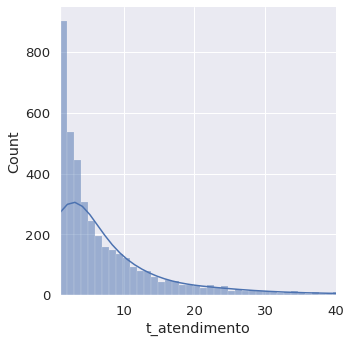

In [64]:
sns.set(font_scale = 1.2)
#sns.set_theme(style="ticks")
#sns.set_xticks([1, 5, 10, 50, 100, 200])
sns_plot = sns.displot(desfechos_juntos['t_atendimento'],kde=True)
sns_plot.set(xlim=[1,40])
#sns.set_xticks([1, 5, 10, 50, 100, 200])
sns_plot.savefig("tempo_dist.png")

##Base Exames##

Importar a base

In [65]:
df=pd.read_csv('HSL_Exames_2.csv',sep='|')

In [66]:
df.head()

,ID_PACIENTE,ID_ATENDIMENTO,DT_COLETA,DE_ORIGEM,DE_EXAME,DE_ANALITO,DE_RESULTADO,CD_UNIDADE,DE_VALOR_REFERENCIA
0,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,2020-05-14,Pronto Socorro,Fosfatase Alcalina,Fosfatase Alcalina,106,U/L,40 - 129
1,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,2020-05-14,Pronto Socorro,Gama Gt,Gama-GT,33,U/L,12 a 73
2,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,2020-05-14,Pronto Socorro,Tgp,ALT (TGP),51,U/L,Até 41
3,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,2020-05-14,Pronto Socorro,Desidrogenase Lática (DHL/L),DHL,530,U/L,240 a 480
4,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,2020-05-14,Pronto Socorro,"Proteína C Reativa, plasma",Proteína C-Reativa,"1,84",mg/dL,Ver resultado tradicional


In [67]:
df.drop(columns=['DE_ORIGEM','DT_COLETA','CD_UNIDADE','ID_ATENDIMENTO']).head()

,ID_PACIENTE,DE_EXAME,DE_ANALITO,DE_RESULTADO,DE_VALOR_REFERENCIA
0,3487791F44C34B421C932DC8616A8437,Fosfatase Alcalina,Fosfatase Alcalina,106,40 - 129
1,3487791F44C34B421C932DC8616A8437,Gama Gt,Gama-GT,33,12 a 73
2,3487791F44C34B421C932DC8616A8437,Tgp,ALT (TGP),51,Até 41
3,3487791F44C34B421C932DC8616A8437,Desidrogenase Lática (DHL/L),DHL,530,240 a 480
4,3487791F44C34B421C932DC8616A8437,"Proteína C Reativa, plasma",Proteína C-Reativa,"1,84",Ver resultado tradicional


Removendo missing values

In [68]:
df = df[np.logical_not(df['DE_VALOR_REFERENCIA'].isna())]

Removendo tuplas com valor de referencia = ver resultado tradicional

In [69]:
df = df[df['DE_VALOR_REFERENCIA']!='Ver resultado tradicional']

Removendo atributos não importantes

In [70]:
df = df.drop(columns=['DE_ORIGEM','DT_COLETA','CD_UNIDADE'])

Código para checar se o resultado do exame foi regular ou não

In [71]:
lista = []
for data in df.iloc:
    referencia_ = data[5].replace(',','.')
    referencia_ = referencia_.replace('/mL','')
    referencia = referencia_.split()
    resultado = data[4].replace(',','.')
    try:
        resultado = float(resultado)
        if len(referencia) == 1:
            if resultado == float(referencia[0]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif (referencia[0] == 'Até' or referencia[0] == 'até'):
            if resultado < float(referencia[1]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[1] == 'a' and referencia[0].lower()!='inferior' and referencia[0].lower()!='superior':
            if resultado > float(referencia[0]) and resultado < float(referencia[2]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[1] == '-':
            if resultado > float(referencia[0]) and resultado < float(referencia[2]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Acima':
            if resultado > float(referencia[2]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == '>':
            if resultado > float(referencia[1]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == '<':
            if resultado < float(referencia[1]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'De':
            if resultado > float(referencia[1]) and resultado < float(referencia[3]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Homens:' and referencia[2] == 'a':
            if resultado > float(referencia[1]) and resultado < float(referencia[3]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Mulheres:':
            if resultado < float(referencia[3]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif (referencia[0] == 'Maior' or referencia[0] == 'maior') and referencia[1] == 'ou':
            if resultado >= float(referencia[4]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif (referencia[0] == 'Maior' or referencia[0] == 'maior') and referencia[1] == 'que':
            if referencia[2] != 'a':
                if resultado > float(referencia[2]):
                    lista.append('Regular')
                else:
                    lista.append('Iregular')
            else:
                if resultado > float(referencia[3]):
                    lista.append('Regular')
                else:
                    lista.append('Iregular')
        elif (referencia[0] == 'Menor' or referencia[0] == 'menor') and referencia[1] == 'ou':
            if resultado <= float(referencia[4]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif (referencia[0] == 'Menor' or referencia[0] == 'menor') and referencia[1] == 'que':
            if resultado < float(referencia[2]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif (referencia[0] == 'Inferior' or referencia[0] == 'inferior') and referencia[1] == 'a':
            if resultado < float(referencia[2]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Superior' and referencia[1] == 'a':
            if resultado > float(referencia[2]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Baixa':
            if resultado < float(referencia[-1]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Normal:':
            if resultado < float(referencia[-1]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Não':
            if resultado < float(referencia[-1]):
                lista.append('Regular')
            else:
                lista.append('Iregular')
        elif referencia[0] == 'Nível':
            if resultado > float(referencia[2]) and resultado < float(referencia[4]) :
                lista.append('Regular')
            else:
                lista.append('Iregular')
        else:
            lista.append('Nao classificado')
    except ValueError:
        if not isinstance(resultado,float):
            if resultado.lower() == referencia_.lower():
                lista.append('Regular')
            elif resultado.lower() == 'não reagente':
                lista.append('Regular')
            elif resultado == 'NÃO DETECTADO (NEGATIVO)':
                lista.append('Regular')
            else:
                lista.append('Iregular')
        else:
            lista.append('erro')

Inclusão desse resultado na tabela

In [72]:
df['RESULTADO'] = lista
df = df[df['RESULTADO']!='erro']

In [73]:
df

,ID_PACIENTE,ID_ATENDIMENTO,DE_EXAME,DE_ANALITO,DE_RESULTADO,DE_VALOR_REFERENCIA,RESULTADO
0,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Fosfatase Alcalina,Fosfatase Alcalina,106,40 - 129,Regular
1,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Gama Gt,Gama-GT,33,12 a 73,Regular
2,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Tgp,ALT (TGP),51,Até 41,Iregular
3,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Desidrogenase Lática (DHL/L),DHL,530,240 a 480,Iregular
5,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Tgo,AST (TGO),35,Até 40,Regular
...,...,...,...,...,...,...,...
631346,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,D. Dimeros(Dimeros De Fibrina),"Dimeros D, quant",856,Até 500,Iregular
631347,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo E Ativid. Protrombina (Tp),TP/INR,"1,1","0,9 a 1,1",Iregular
631348,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo E Ativid. Protrombina (Tp),Tempo de Protrombina,"12,6","10,1 a 12,8",Regular
631349,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo Tromb.Parcial Ativada,TTPA,"29,6","25,4 a 33,4",Regular


Código para diminuir número de tipos de exames

In [74]:
lista = []
for i, data in enumerate(df.iloc):
    split = data[2].split()
    if split[0] == 'Sódio' or split[0] == 'Sódio,':
        df.iloc[i,2] = 'Sódio'
    if split[0] == 'Testosterona':
        df.iloc[i,2] = 'Testosterona' 
    if split[0] == 'Triglicerídeos' or split[0] == 'Triglicérides':
        df.iloc[i,2] = 'Testosterona'
    if split[0] == 'Urina' or split[0] == 'Urina,':
        df.iloc[i,2] = 'Urina'
    if split[0] == 'Ácido' and (split[1] == 'Úrico' or split[1] == 'Úrico,'):
        df.iloc[i,2] = 'Urina'
    if split[0] == 'Rast':
        df.iloc[i,2] = 'Rast'
    if split[0] == 'Reticulócitos,':
        df.iloc[i,2] = 'Reticulócitos'
    if split[0] == 'Proteínas':
        df.iloc[i,2] = 'Proteínas'
    if split[0] == 'Potássio':
        df.iloc[i,2] = 'Potássio'
    if split[0] == 'Plaquetas,':
        df.iloc[i,2] = 'Plaquetas'
    if split[0] == 'Paratormonio' or split[0] == 'Paratormonio,':
        df.iloc[i,2] = 'Paratormonio'
    if split[0] == 'Linfócitos' or split[0] == 'Linfocitos':
        df.iloc[i,2] = 'Linfócitos'
    if split[0] == 'Imunoglobulina' or split[0] == 'Imunoglobulinas':
        df.iloc[i,2] = 'Imunoglobulina'
    if split[0] == 'Hepat.B':
        df.iloc[i,2] = 'Hepat.B'
    if split[0] == 'Glicemia':
        df.iloc[i,2] = 'Glicemia'
    if split[0] == 'Fostase':
        df.iloc[i,2] = 'Fostase'
    if split[0] == 'Dengue,':
        df.iloc[i,2] = 'Dengue'
    if split[0] == 'Cálcio':
        df.iloc[i,2] = 'Cálcio'
    if split[0] == 'Creatinina':
        df.iloc[i,2] = 'Creatinina'
    if split[0] == 'Colesterol':
        df.iloc[i,2] = 'Colesterol'
    if split[0] == 'Citomegalovírus' or split[0] == 'Citomegalovírus,':
        df.iloc[i,2] = 'Citomegalovírus'
    if split[0][:5] == 'COVID' or data[2] == 'Sorologia - Coronavírus, IgA' or data[2] == 'Sorologia - Coronavírus, IgG':
        df.iloc[i,2] = 'COVID'
    if data[2] == 'Detecção de Coronavírus (NCoV-2019) POR PCR (Anatomia Patológica)':
        df.iloc[i,2] = 'COVID'
    if split[0] == 'Mioglobina':
        df.iloc[i,2] = 'Mioglobina'
    if split[0] == 'Lactato':
        df.iloc[i,2] = 'Lactato'
    if split[0] == 'Fosfatase':
        df.iloc[i,2] = 'Fosfatase'
    if split[0] == 'Fósforo' and split[0] == 'Fósforo,':
        df.iloc[i,2] = 'Lactato'
    if split[0][:5] == 'Fezes':
        df.iloc[i,2] = 'Fezes'
    if split[0] == 'Ferro':
        df.iloc[i,2] = 'Ferro'
    if split[0] == 'Complemento' or split[0] == 'Complemento/O':
        df.iloc[i,2] = 'Complemento C'
    if split[0] == 'Cloro' and split[0] == 'Cloro,':
        df.iloc[i,2] = 'Cloro'

In [75]:
df

,ID_PACIENTE,ID_ATENDIMENTO,DE_EXAME,DE_ANALITO,DE_RESULTADO,DE_VALOR_REFERENCIA,RESULTADO
0,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Fosfatase,Fosfatase Alcalina,106,40 - 129,Regular
1,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Gama Gt,Gama-GT,33,12 a 73,Regular
2,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Tgp,ALT (TGP),51,Até 41,Iregular
3,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Desidrogenase Lática (DHL/L),DHL,530,240 a 480,Iregular
5,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Tgo,AST (TGO),35,Até 40,Regular
...,...,...,...,...,...,...,...
631346,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,D. Dimeros(Dimeros De Fibrina),"Dimeros D, quant",856,Até 500,Iregular
631347,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo E Ativid. Protrombina (Tp),TP/INR,"1,1","0,9 a 1,1",Iregular
631348,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo E Ativid. Protrombina (Tp),Tempo de Protrombina,"12,6","10,1 a 12,8",Regular
631349,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo Tromb.Parcial Ativada,TTPA,"29,6","25,4 a 33,4",Regular


In [76]:
len(df['DE_EXAME'].unique())

308

Removendo vírgulas

In [77]:
for i, data in enumerate(df.iloc):
    df.iloc[i,2] = df.iloc[i,2].replace(',','')

In [78]:
df

,ID_PACIENTE,ID_ATENDIMENTO,DE_EXAME,DE_ANALITO,DE_RESULTADO,DE_VALOR_REFERENCIA,RESULTADO
0,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Fosfatase,Fosfatase Alcalina,106,40 - 129,Regular
1,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Gama Gt,Gama-GT,33,12 a 73,Regular
2,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Tgp,ALT (TGP),51,Até 41,Iregular
3,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Desidrogenase Lática (DHL/L),DHL,530,240 a 480,Iregular
5,3487791F44C34B421C932DC8616A8437,F924F6CEA1539FEFDCE7C252DFA5AF99,Tgo,AST (TGO),35,Até 40,Regular
...,...,...,...,...,...,...,...
631346,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,D. Dimeros(Dimeros De Fibrina),"Dimeros D, quant",856,Até 500,Iregular
631347,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo E Ativid. Protrombina (Tp),TP/INR,"1,1","0,9 a 1,1",Iregular
631348,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo E Ativid. Protrombina (Tp),Tempo de Protrombina,"12,6","10,1 a 12,8",Regular
631349,885F6BBB7D21E0534D3661DF90A95EE7,2DA3DDF67951688C614BBDB6F40F0A87,Tempo Tromb.Parcial Ativada,TTPA,"29,6","25,4 a 33,4",Regular


Removendo mais atributos não relevantes

In [79]:
df = df.drop(['DE_RESULTADO','DE_VALOR_REFERENCIA'],axis=1)
df = df.drop(['ID_ATENDIMENTO'],axis=1)

Visualização do novo dataframe

In [80]:
df

,ID_PACIENTE,DE_EXAME,DE_ANALITO,RESULTADO
0,3487791F44C34B421C932DC8616A8437,Fosfatase,Fosfatase Alcalina,Regular
1,3487791F44C34B421C932DC8616A8437,Gama Gt,Gama-GT,Regular
2,3487791F44C34B421C932DC8616A8437,Tgp,ALT (TGP),Iregular
3,3487791F44C34B421C932DC8616A8437,Desidrogenase Lática (DHL/L),DHL,Iregular
5,3487791F44C34B421C932DC8616A8437,Tgo,AST (TGO),Regular
...,...,...,...,...
631346,885F6BBB7D21E0534D3661DF90A95EE7,D. Dimeros(Dimeros De Fibrina),"Dimeros D, quant",Iregular
631347,885F6BBB7D21E0534D3661DF90A95EE7,Tempo E Ativid. Protrombina (Tp),TP/INR,Iregular
631348,885F6BBB7D21E0534D3661DF90A95EE7,Tempo E Ativid. Protrombina (Tp),Tempo de Protrombina,Regular
631349,885F6BBB7D21E0534D3661DF90A95EE7,Tempo Tromb.Parcial Ativada,TTPA,Regular


Deletando duplicatas

In [81]:
df_juntos = df.drop_duplicates('ID_PACIENTE')

Coletando os diferentes IDs

In [82]:
unique=df_juntos['ID_PACIENTE']

Código para unir os exames e resultados em um único ID

In [83]:
dic={}
for i,id in enumerate(unique):
    dic[id]=i
exames = ['']*len(unique)
problemas = ['']*len(unique)
resultado = ['']*len(unique)
total_exames = [0]*len(unique)
total_problemas = [0]*len(unique)
for data in df.iloc:
    if data[0] in dic:
        total_exames[dic[data[0]]] += 1
        if exames[dic[data[0]]] == '':
            exames[dic[data[0]]]+=str(data[1])
        else:
            exames[dic[data[0]]]+=','+str(data[1])
        if data[3] == 'Iregular':
            total_problemas[dic[data[0]]] += 1
            if problemas[dic[data[0]]] == '':
                problemas[dic[data[0]]]+=str(data[1])
            else:
                problemas[dic[data[0]]]+=','+str(data[1])
df_juntos['exames'] = exames
df_juntos['problemas'] = problemas
df_juntos['total_exames'] = total_exames
df_juntos['total_problemas'] = total_problemas

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Removendo mais atributos não ncessários

In [84]:
df_juntos

,ID_PACIENTE,DE_EXAME,DE_ANALITO,RESULTADO,exames,problemas,total_exames,total_problemas
0,3487791F44C34B421C932DC8616A8437,Fosfatase,Fosfatase Alcalina,Regular,"Fosfatase,Gama Gt,Tgp,Desidrogenase Lática (DH...","Tgp,Desidrogenase Lática (DHL/L),Fibrinogênio ...",109,38
149,0AD1FFA4419472256666A3445414F1F9,COVID,Coronavírus (2019-nCoV),Iregular,COVID,COVID,1,1
151,B8A474D172DDB5BAD11F088BDA20BE96,Interleucina 6 soro,Interleucina 6,Iregular,"Interleucina 6 soro,Urina,Urina,Urina,Urina,Ur...","Interleucina 6 soro,Urina,Urina,Urina,Urina,Ur...",155,70
348,FD6F18D3E9DA3ADD5179E6B3EA21ABB2,COVID,Coronavírus (2019-nCoV),Iregular,COVID,COVID,1,1
350,3B9836D0E92704BFAB0B2E691D0A3BAE,Antígeno Influenza Teste Rápido (AGINFLU),Influenza A e B - teste rápido,Regular,"Antígeno Influenza Teste Rápido (AGINFLU),COVI...",COVID,4,1
...,...,...,...,...,...,...,...,...
631197,782656BA1BADE181CC5B4DE5792C91BE,COVID,Detecção de Coronavírus (NCoV-2019) POR PCR (A...,Iregular,"COVID,Hemograma,Hemograma,Hemograma,Hemograma,...","COVID,Hemograma,Hemograma,Hemograma,Hemograma,...",75,26
631295,74CC17F4F6DDAB860A70F7CCC2F8CF82,COVID,Coronavírus (2019-nCoV),Iregular,"COVID,Antígeno Influenza Teste Rápido (AGINFLU)",COVID,2,1
631298,50061499481B4B35DB108EB436A05500,COVID,Coronavírus (2019-nCoV),Iregular,COVID,COVID,1,1
631300,1F382C34C14A2CC6DDD05825801EF68E,COVID,Coronavírus (2019-nCoV),Iregular,COVID,COVID,1,1


In [85]:
df_juntos = df_juntos.drop(['DE_EXAME','DE_ANALITO','RESULTADO'],axis=1)

Visualização do dataframe junto

In [86]:
df_juntos.head()

,ID_PACIENTE,exames,problemas,total_exames,total_problemas
0,3487791F44C34B421C932DC8616A8437,"Fosfatase,Gama Gt,Tgp,Desidrogenase Lática (DH...","Tgp,Desidrogenase Lática (DHL/L),Fibrinogênio ...",109,38
149,0AD1FFA4419472256666A3445414F1F9,COVID,COVID,1,1
151,B8A474D172DDB5BAD11F088BDA20BE96,"Interleucina 6 soro,Urina,Urina,Urina,Urina,Ur...","Interleucina 6 soro,Urina,Urina,Urina,Urina,Ur...",155,70
348,FD6F18D3E9DA3ADD5179E6B3EA21ABB2,COVID,COVID,1,1
350,3B9836D0E92704BFAB0B2E691D0A3BAE,"Antígeno Influenza Teste Rápido (AGINFLU),COVI...",COVID,4,1


##Base Pacientes##

Importar a base de dados

In [87]:
pacientes = pd.read_csv('HSL_Pacientes_2.csv',sep='|')

In [88]:
pacientes.head()

,ID_PACIENTE,IC_SEXO,AA_NASCIMENTO,CD_PAIS,CD_UF,CD_MUNICIPIO,CD_CEPREDUZIDO
0,3487791F44C34B421C932DC8616A8437,M,1963,BR,SP,MMMM,CCCC
1,0AD1FFA4419472256666A3445414F1F9,M,1969,BR,SP,SAO PAULO,CCCC
2,BE35D08CF3EF6F114E9935F6D72C49FA,M,1964,BR,SP,SAO PAULO,CCCC
3,962F4020D456AAB602B356E57238EF42,F,1959,BR,SP,SAO PAULO,CCCC
4,F983089DAC62E42124227C856AE3444C,M,1947,BR,SP,MMMM,CCCC


In [89]:
pacientes['CD_PAIS'].unique()

array(['BR', 'XX'], dtype=object)

Removendo atributos irrelevantes

In [90]:
pacientes = pacientes.drop(['CD_PAIS','CD_UF','CD_MUNICIPIO','CD_CEPREDUZIDO'],axis=1)

Removendo missing values

In [91]:
pacientes = pacientes[pacientes['AA_NASCIMENTO']!='AAAA']
pacientes = pacientes[pacientes['AA_NASCIMENTO']!='YYYY']

Transformação do ano de nascimento em idade

In [92]:
idade = []
for data in pacientes.iloc:
    idade.append(2020 - int(data[2]))
pacientes['idade'] = idade

Visualização da distribuição de idade

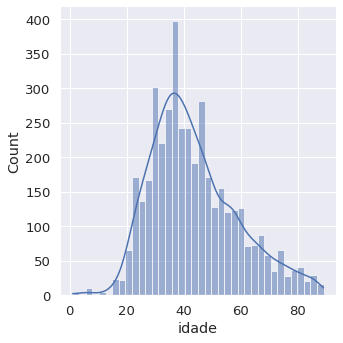

In [93]:
sns.set(font_scale = 1.2)
sns_plot = sns.displot(pacientes,x="idade",kde=True)
sns_plot.savefig("idade_dist.png")

In [94]:
pacientes['idade'].describe()

count    4141.000000
mean       43.504468
std        15.273807
min         1.000000
25%        33.000000
50%        41.000000
75%        52.000000
max        89.000000
Name: idade, dtype: float64

Deletando ano de nascimento

In [95]:
pacientes = pacientes.drop(['AA_NASCIMENTO'],axis=1)

##União das bases##

Unindo pacientes com desfechos em um dataframe

In [96]:
desfechos_juntos = desfechos_juntos.rename(columns={"id_paciente": "ID_PACIENTE"})
desfecho_pacientes = desfechos_juntos.merge(pacientes,how='left')

Inserindo missing values

In [97]:
desfecho_pacientes[np.logical_not(desfecho_pacientes['idade'].isna())]

,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade
2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0
3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0
7,BB7523C235A6582C309BB3E4F8C93698,Internado,O,2,20,M,87.0
8,D831A012023DCACDE4E8B9483AD5A438,Internado,O,15,171,M,79.0
10,F115058FEF0C6CE66E32EF72AB785F48,Internado,O,1,27,M,81.0
...,...,...,...,...,...,...,...
4188,A29ADDE51D11887EABFF9CC70E5F9A72,Pronto Atendimento,A,1,1,M,21.0
4189,50061499481B4B35DB108EB436A05500,Externo,A,2,2,M,28.0
4190,74CC17F4F6DDAB860A70F7CCC2F8CF82,Ambulatorial,A,5,5,F,26.0
4191,1F382C34C14A2CC6DDD05825801EF68E,Pronto Atendimento,A,6,6,F,27.0


In [98]:
# Dados retirados da base
desfecho_pacientes.iloc[0,-2] = 'M'
desfecho_pacientes.iloc[1,-2] = 'M'
desfecho_pacientes.iloc[4,-2] = 'M'
desfecho_pacientes.iloc[5,-2] = 'M'
desfecho_pacientes.iloc[6,-2] = 'M'
desfecho_pacientes.iloc[9,-2] = 'M' 
desfecho_pacientes.iloc[14,-2] = 'M'
desfecho_pacientes.iloc[20,-2] = 'F'
desfecho_pacientes.iloc[21,-2] = 'M'
desfecho_pacientes.iloc[27,-2] = 'M'
desfecho_pacientes.iloc[30,-2] = 'F'
desfecho_pacientes.iloc[31,-2] = 'F'
desfecho_pacientes.iloc[33,-2] = 'F'
desfecho_pacientes.iloc[36,-2] = 'F'
desfecho_pacientes.iloc[40,-2] = 'F'
desfecho_pacientes.iloc[42,-2] = 'F'

# Dados estimados para completar o estudo
desfecho_pacientes.iloc[0,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[1,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[4,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[5,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[6,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[9,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[14,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[20,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[21,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[27,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[30,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[31,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[33,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[36,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[40,-1] = int(random.gauss(76.931034,10.443491))
desfecho_pacientes.iloc[42,-1] = int(random.gauss(76.931034,10.443491))

Unindo todos os dataframes

In [99]:
df = desfecho_pacientes.merge(df_juntos,how='left')

Removendo missing values

In [100]:
df = df[np.logical_not(df['total_exames'].isna())]

Exclusão de problemas e exames iguais e contagem apenas de problemas diferentes

In [101]:
df

,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas
0,BA74194B979B086198794D1470107709,Internado,O,1,11,M,70.0,"Ferritina Dosagem,D. Dimeros(Dimeros De Fibrin...","Ferritina Dosagem,D. Dimeros(Dimeros De Fibrin...",523.0,301.0
2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Lactato,Desidrogenase Lática (DHL/L),Sódio,Cre...","Lactato,Desidrogenase Lática (DHL/L),Sódio,Cre...",1123.0,689.0
3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Cálcio,Hemograma,Hemograma,Hemograma,Hemograma...","Hemograma,Hemograma,Hemograma,Hemograma,Hemogr...",318.0,130.0
4,44DA670729D76F0264E6066E2E42CF45,Internado,O,2,66,M,67.0,"Hepat.B,Hepatite C Anti-Hcv Sorologia,Hepat.B,...","COVID,Gasometria Arterial,Gasometria Arterial,...",3097.0,1835.0
5,A6567EA4CB76E002B7BEADD005279297,Internado,O,1,34,M,70.0,"Fósforo,Calculo da Estimativa da Taxa de Filtr...","Fósforo,Calculo da Estimativa da Taxa de Filtr...",1431.0,900.0
...,...,...,...,...,...,...,...,...,...,...,...
4187,782656BA1BADE181CC5B4DE5792C91BE,Pronto Atendimento,A,1,5,F,89.0,"COVID,Hemograma,Hemograma,Hemograma,Hemograma,...","COVID,Hemograma,Hemograma,Hemograma,Hemograma,...",75.0,26.0
4189,50061499481B4B35DB108EB436A05500,Externo,A,2,2,M,28.0,COVID,COVID,1.0,1.0
4190,74CC17F4F6DDAB860A70F7CCC2F8CF82,Ambulatorial,A,5,5,F,26.0,"COVID,Antígeno Influenza Teste Rápido (AGINFLU)",COVID,2.0,1.0
4191,1F382C34C14A2CC6DDD05825801EF68E,Pronto Atendimento,A,6,6,F,27.0,COVID,COVID,1.0,1.0


In [102]:
problemas = []
exames = []
total_problemas = []
for i,data in enumerate(df.iloc):
    vetor = data[-3].split(',')
    vetor = list(set(vetor))
    total_problemas.append(len(vetor))
    problemas.append(','.join(vetor))
    vetor_exames = data[-4].split(',')
    vetor_exames = list(set(vetor_exames))
    exames.append(','.join(vetor_exames))
df['total_problemas'] = total_problemas
df['problemas'] = problemas
df['exames'] = exames

Removendo missing values

In [103]:
df = df[np.logical_not(df['idade'].isna())]

Visualização do dataframe final

In [104]:
df

,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas
0,BA74194B979B086198794D1470107709,Internado,O,1,11,M,70.0,"Tgp,Bilirrubinas Total E Fracoes,Tempo Tromb.P...","Bilirrubinas Total E Fracoes,Tempo Tromb.Parci...",523.0,31
2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Hepatite C Anti-Hcv Sorologia,Tgp,Bilirrubinas...","Tgp,Bilirrubinas Total E Fracoes,Fator II Ativ...",1123.0,40
3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Tgp,Bilirrubinas Total E Fracoes,Tempo Tromb.P...","Bilirrubinas Total E Fracoes,Tempo Tromb.Parci...",318.0,21
4,44DA670729D76F0264E6066E2E42CF45,Internado,O,2,66,M,67.0,"Hepatite C Anti-Hcv Sorologia,Tgp,Bilirrubinas...","Tgp,Bilirrubinas Total E Fracoes,Tempo Tromb.P...",3097.0,42
5,A6567EA4CB76E002B7BEADD005279297,Internado,O,1,34,M,70.0,"Tgp,Bilirrubinas Total E Fracoes,Tempo Tromb.P...","Bilirrubinas Total E Fracoes,D. Dimeros(Dimero...",1431.0,27
...,...,...,...,...,...,...,...,...,...,...,...
4187,782656BA1BADE181CC5B4DE5792C91BE,Pronto Atendimento,A,1,5,F,89.0,"COVID,Tgp,Uréia,Cálcio,Sódio,Potássio,D. Dimer...","Potássio,D. Dimeros(Dimeros De Fibrina),Tgo,CO...",75.0,7
4189,50061499481B4B35DB108EB436A05500,Externo,A,2,2,M,28.0,COVID,COVID,1.0,1
4190,74CC17F4F6DDAB860A70F7CCC2F8CF82,Ambulatorial,A,5,5,F,26.0,"Antígeno Influenza Teste Rápido (AGINFLU),COVID",COVID,2.0,1
4191,1F382C34C14A2CC6DDD05825801EF68E,Pronto Atendimento,A,6,6,F,27.0,COVID,COVID,1.0,1


Salvando o dataframe final

In [105]:
df.to_csv('HSL_idade.csv')

#Regras de Associação#

##Transformação para o apriori##

Importando o dataframe já transformado

In [ ]:
df=pd.read_csv('HSL.csv',sep=',')

Removendo coluna Unnamed

In [ ]:
df = df.drop('Unnamed: 0',axis=1)

Dando suporte aos pacientes que tem nenhum problema

In [ ]:
df['problemas'].iloc[204]# = 'sem problemas'
#df['problemas'].iloc[3057]# = 'sem problemas'

nan

Para usar o apriori o dataset precisa estar no formato lista de listas

In [ ]:
df

,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas
0,BA74194B979B086198794D1470107709,Internado,O,1,11,M,70.0,"Tempo E Ativid. Protrombina (Tp),Tsh - Hormoni...","Tempo E Ativid. Protrombina (Tp),Desidrogenase...",523.0,31
1,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Acido F...",1123.0,40
2,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",318.0,21
3,44DA670729D76F0264E6066E2E42CF45,Internado,O,2,66,M,85.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...",3097.0,42
4,A6567EA4CB76E002B7BEADD005279297,Internado,O,1,34,M,84.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",1431.0,27
...,...,...,...,...,...,...,...,...,...,...,...
4133,782656BA1BADE181CC5B4DE5792C91BE,Pronto Atendimento,A,1,5,F,89.0,Calculo da Estimativa da Taxa de Filtracao Glo...,Calculo da Estimativa da Taxa de Filtracao Glo...,75.0,7
4134,50061499481B4B35DB108EB436A05500,Externo,A,2,2,M,28.0,COVID,COVID,1.0,1
4135,74CC17F4F6DDAB860A70F7CCC2F8CF82,Ambulatorial,A,5,5,F,26.0,"Antígeno Influenza Teste Rápido (AGINFLU),COVID",COVID,2.0,1
4136,1F382C34C14A2CC6DDD05825801EF68E,Pronto Atendimento,A,6,6,F,27.0,COVID,COVID,1.0,1


In [ ]:
df=df[np.logical_not(df['problemas'].isna())]

In [ ]:
df['t_atendimento']=df['t_atendimento'].apply(lambda x: 'ACIMA' if x > 30 else 'ABAIXO')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas
0,BA74194B979B086198794D1470107709,Internado,O,1,ABAIXO,M,70.0,"Tempo E Ativid. Protrombina (Tp),Tsh - Hormoni...","Tempo E Ativid. Protrombina (Tp),Desidrogenase...",523.0,31
1,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,ABAIXO,M,84.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Acido F...",1123.0,40
2,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,ABAIXO,M,78.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",318.0,21
3,44DA670729D76F0264E6066E2E42CF45,Internado,O,2,ACIMA,M,85.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...",3097.0,42
4,A6567EA4CB76E002B7BEADD005279297,Internado,O,1,ACIMA,M,84.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",1431.0,27
...,...,...,...,...,...,...,...,...,...,...,...
4133,782656BA1BADE181CC5B4DE5792C91BE,Pronto Atendimento,A,1,ABAIXO,F,89.0,Calculo da Estimativa da Taxa de Filtracao Glo...,Calculo da Estimativa da Taxa de Filtracao Glo...,75.0,7
4134,50061499481B4B35DB108EB436A05500,Externo,A,2,ABAIXO,M,28.0,COVID,COVID,1.0,1
4135,74CC17F4F6DDAB860A70F7CCC2F8CF82,Ambulatorial,A,5,ABAIXO,F,26.0,"Antígeno Influenza Teste Rápido (AGINFLU),COVID",COVID,2.0,1
4136,1F382C34C14A2CC6DDD05825801EF68E,Pronto Atendimento,A,6,ABAIXO,F,27.0,COVID,COVID,1.0,1


In [ ]:
registros_exames = []
registros_problemas = []
for data in df['exames'].iloc:
  registros_exames.append(data.split(','))
for data in df['problemas'].iloc:
  registros_problemas.append(data.split(','))
for i,data in enumerate(registros_problemas):
   data.append(df['de_tipo_atendimento'].iloc[i])

Importando o a apriori

In [ ]:
!pip install apyori
!pip install mlxtend 
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Modificando o formato e gerando conjuntos de itens frequentes

In [ ]:
dataset = registros_problemas
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.03, use_colnames=True)

frequent_itemsets

,support,itemsets
0,0.040135,(Albumina)
1,0.190039,(Ambulatorial)
2,0.182785,(Bilirrubinas Total E Fracoes)
3,0.992747,(COVID)
4,0.361702,(Calculo da Estimativa da Taxa de Filtracao Gl...
...,...,...
110512,0.030222,"(D. Dimeros(Dimeros De Fibrina), Gasometria Ve..."
110513,0.031673,"(D. Dimeros(Dimeros De Fibrina), Gasometria Ve..."
110514,0.031190,"(D. Dimeros(Dimeros De Fibrina), Gasometria Ve..."
110515,0.030222,"(D. Dimeros(Dimeros De Fibrina), Gasometria Ve..."


Gerando um dataframe com as regras e suas métricas

In [ ]:
df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

KeyboardInterrupt: ignored

In [ ]:
df

Filtro para COVID no consequente

In [ ]:
covid_consequent = df[df['consequents'].apply(lambda x: 'COVID' in (x) and len(x) == 1)]

Filtro para COVID no antecedente

In [ ]:
covid_antecedent = df[df['antecedents'].apply(lambda x: 'COVID' in (x) and len(x) == 1)]

In [ ]:
consequent = df[df['consequents'].apply(lambda x: 'Internado' in (x) and len(x) == 1)]

NameError: ignored

In [ ]:
consequent[consequent['lift']>1.5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
35,(Creatinina),(ACIMA),0.127418,0.05972,0.030948,0.242884,4.067082,0.023338,1.241924
1688,"(Creatinina, Hemograma)",(ACIMA),0.126692,0.05972,0.030948,0.244275,4.090367,0.023382,1.244210


Filtro para regras com Lift > 15

In [ ]:
df[df['lift']>18.0]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1586243,"(Uréia, Fósforo, Tempo E Ativid. Protrombina (...","(Lactato, Potássio, Tempo Tromb.Parcial Ativada)",0.040377,0.041103,0.030222,0.748503,18.210638,0.028563,3.812759
1586252,"(Lactato, Potássio, Tempo Tromb.Parcial Ativada)","(Uréia, Fósforo, Tempo E Ativid. Protrombina (...",0.041103,0.040377,0.030222,0.735294,18.210638,0.028563,3.625242
3595228,"(Uréia, Lactato, Tempo E Ativid. Protrombina (...","(Fósforo, Tempo Tromb.Parcial Ativada)",0.039652,0.042311,0.030222,0.762195,18.013937,0.028545,4.027203
3595247,"(Lactato, Uréia, Tempo E Ativid. Protrombina (...","(Fósforo, Potássio, Tempo Tromb.Parcial Ativada)",0.041586,0.040135,0.030222,0.726744,18.107313,0.028553,3.512696
3595253,"(Lactato, Uréia, Tempo E Ativid. Protrombina (...","(Fósforo, Gasometria Venosa, Tempo Tromb.Parci...",0.039894,0.041586,0.030222,0.757576,18.217054,0.028563,3.953457
3595258,"(Uréia, Fósforo, Tempo E Ativid. Protrombina (...","(Lactato, Potássio, Tempo Tromb.Parcial Ativada)",0.040135,0.041103,0.030222,0.753012,18.320340,0.028573,3.882365
3595271,"(Lactato, Potássio, Gasometria Venosa, Tempo T...","(Uréia, Fósforo, Tempo E Ativid. Protrombina (...",0.041103,0.040377,0.030222,0.735294,18.210638,0.028563,3.625242
3595280,"(Potássio, Fósforo, Gasometria Venosa, Tempo T...","(Lactato, Uréia, Tempo E Ativid. Protrombina (...",0.039652,0.042070,0.030222,0.762195,18.117466,0.028554,4.028220
3595283,"(Lactato, Uréia, Tempo E Ativid. Protrombina (...","(Potássio, Fósforo, Gasometria Venosa, Tempo T...",0.042070,0.039652,0.030222,0.718391,18.117466,0.028554,3.410216
3595292,"(Uréia, Fósforo, Tempo E Ativid. Protrombina (...","(Lactato, Potássio, Gasometria Venosa, Tempo T...",0.040377,0.041103,0.030222,0.748503,18.210638,0.028563,3.812759


#Clusterização#

Importando o dataframe já transformado

In [256]:
df=pd.read_csv('HSL_idade.csv',sep=',')

Remoção de atributos, Unnamed: 0 e ID PACIENTE são removidos pois são identificadores, exames	e problemas são removidospor serem muito particulares e já usados para regras de associação, tipo de atendimento e de_desfecho são removidos por serem possíveis rótulos.

In [257]:
df

,Unnamed: 0,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas
0,2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",1123.0,40
1,3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",318.0,21
2,7,BB7523C235A6582C309BB3E4F8C93698,Internado,O,2,20,M,87.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",552.0,35
3,8,D831A012023DCACDE4E8B9483AD5A438,Internado,O,15,171,M,79.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",2130.0,40
4,10,F115058FEF0C6CE66E32EF72AB785F48,Internado,O,1,27,M,81.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",2481.0,37
...,...,...,...,...,...,...,...,...,...,...,...,...
4010,4187,782656BA1BADE181CC5B4DE5792C91BE,Pronto Atendimento,A,1,5,F,89.0,Calculo da Estimativa da Taxa de Filtracao Glo...,Calculo da Estimativa da Taxa de Filtracao Glo...,75.0,7
4011,4189,50061499481B4B35DB108EB436A05500,Externo,A,2,2,M,28.0,COVID,COVID,1.0,1
4012,4190,74CC17F4F6DDAB860A70F7CCC2F8CF82,Ambulatorial,A,5,5,F,26.0,"COVID,Antígeno Influenza Teste Rápido (AGINFLU)",COVID,2.0,1
4013,4191,1F382C34C14A2CC6DDD05825801EF68E,Pronto Atendimento,A,6,6,F,27.0,COVID,COVID,1.0,1


In [258]:
df_cluster = df.drop(['de_tipo_atendimento','de_desfecho','ID_PACIENTE','Unnamed: 0','exames','problemas'],axis=1)

In [259]:
df_cluster = df_cluster.drop('IC_SEXO',axis=1)

In [260]:
df_cluster.head()

,n_atendimentos,t_atendimento,idade,total_exames,total_problemas
0,2,30,84.0,1123.0,40
1,2,13,78.0,318.0,21
2,2,20,87.0,552.0,35
3,15,171,79.0,2130.0,40
4,1,27,81.0,2481.0,37


##k-Means##

In [261]:
import sklearn
from sklearn import cluster

In [262]:
KMeans = cluster.KMeans

O melhor a se fazer, quando trabalhamos com atributos normalizados, e os grupos masculinos e femininos tem aproximadamente o mesmo tamanho é deixar o atributo sexo de lado. Por isso removemos este atributo

In [263]:
df_cluster = df_cluster.drop(['IC_SEXO'], axis = 1)

KeyError: "['IC_SEXO'] not found in axis"

In [264]:
df_cluster = df_cluster[np.logical_not(df_cluster['idade'].isna())]
df = df[np.logical_not(df['idade'].isna())]

Normalização dos dados

In [265]:
from sklearn import preprocessing

df_cluster_n = preprocessing.minmax_scale(df_cluster, feature_range=(0,1), axis=0, copy=True)

max_list = np.max(df_cluster)
min_list = np.min(df_cluster)
for i, max in enumerate(max_list):
  df_cluster.iloc[:,i] = (df_cluster.iloc[:,i] - min_list[i])/(max - min_list[i])

In [266]:
df_cluster

,n_atendimentos,t_atendimento,idade,total_exames,total_problemas
0,0.013333,0.138095,0.943182,0.233070,0.639344
1,0.013333,0.057143,0.875000,0.065850,0.327869
2,0.013333,0.090476,0.977273,0.114458,0.557377
3,0.186667,0.809524,0.886364,0.442252,0.639344
4,0.000000,0.123810,0.909091,0.515164,0.590164
...,...,...,...,...,...
4010,0.000000,0.019048,1.000000,0.015372,0.098361
4011,0.013333,0.004762,0.306818,0.000000,0.000000
4012,0.053333,0.019048,0.284091,0.000208,0.000000
4013,0.066667,0.023810,0.295455,0.000000,0.000000


Criação dos clusters

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_cluster)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_cluster, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.513998126836653
For n_clusters = 3 The average silhouette_score is : 0.40345329658674817
For n_clusters = 4 The average silhouette_score is : 0.3335345517433851
For n_clusters = 5 The average silhouette_score is : 0.30504792486489546
For n_clusters = 6 The average silhouette_score is : 0.3213579099474481
For n_clusters = 7 The average silhouette_score is : 0.33581967607982677
For n_clusters = 8 The average silhouette_score is : 0.31726914969968295
For n_clusters = 9 The average silhouette_score is : 0.3098309540086947
For n_clusters = 10 The average silhouette_score is : 0.31933276833879554


In [267]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_cluster)

In [268]:
len(kmeans.labels_)

4015

In [269]:
df['cluster'] = kmeans.labels_

Centróides

In [270]:
df_cluster

,n_atendimentos,t_atendimento,idade,total_exames,total_problemas
0,0.013333,0.138095,0.943182,0.233070,0.639344
1,0.013333,0.057143,0.875000,0.065850,0.327869
2,0.013333,0.090476,0.977273,0.114458,0.557377
3,0.186667,0.809524,0.886364,0.442252,0.639344
4,0.000000,0.123810,0.909091,0.515164,0.590164
...,...,...,...,...,...
4010,0.000000,0.019048,1.000000,0.015372,0.098361
4011,0.013333,0.004762,0.306818,0.000000,0.000000
4012,0.053333,0.019048,0.284091,0.000208,0.000000
4013,0.066667,0.023810,0.295455,0.000000,0.000000


In [276]:
df[df['cluster']==1]

,Unnamed: 0,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas,cluster
0,2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",1123.0,40,1
1,3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",318.0,21,1
2,7,BB7523C235A6582C309BB3E4F8C93698,Internado,O,2,20,M,87.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",552.0,35,1
3,8,D831A012023DCACDE4E8B9483AD5A438,Internado,O,15,171,M,79.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",2130.0,40,1
4,10,F115058FEF0C6CE66E32EF72AB785F48,Internado,O,1,27,M,81.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",2481.0,37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,4171,47C613AC194445893CBBC996980D04E8,Internado,A,5,16,M,57.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Urina,Calculo da Estimativa da Taxa de Filtrac...",285.0,15,1
3997,4173,E7C710BC34CDC2189CE6E59DFA3274C5,Internado,A,1,7,M,76.0,"Desidrogenase Lática (DHL/L),Creatinina,Fator ...","D. Dimeros(Dimeros De Fibrina),Hemograma,COVID...",120.0,6,1
4001,4177,7DC4B107D4CE5B9BC36CE36F8532BD34,Internado,A,1,17,M,67.0,"Desidrogenase Lática (DHL/L),Uréia,Cloro urgen...","Desidrogenase Lática (DHL/L),Cloro urgente san...",541.0,32,1
4006,4182,7BD39A5ECEEA4B3DA1A0F33C280EAA6E,Internado,A,1,8,M,76.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",Calculo da Estimativa da Taxa de Filtracao Glo...,192.0,15,1


In [ ]:
centroides_n = kmeans.cluster_centers_

In [ ]:
centroides_n

array([[0.03788158, 0.03045228, 0.41279574, 0.00534553, 0.03190653],
       [0.04310292, 0.0783465 , 0.73078132, 0.07911353, 0.23394651]])

Centróides não normalizados

In [ ]:
centroides = centroides_n.copy()
for i,max in enumerate(max_list):
  centroides[:,i] = centroides_n[:,i]*(max - min_list[i]) + min_list[i]

Repare que os centroides dividem os pacientes em um grupo com mais exames, mais tempo de atendimento, maior idade, maior número de exames e maior número de problemas e outro com quantidades menores

In [ ]:
centroides

array([[  3.84111853,   7.39497935,  37.32602479,  26.73339689,
          2.94629806],
       [  4.23271889,  17.45276498,  65.30875576, 381.85253456,
         15.27073733]])

Todos os pacientes que vieram a óbito se encontram no mesmo grupo, e a maioria dos pacientes que tiveram alta se encontram no grupo de menores quantidades

In [ ]:
cluster_o = df[df['de_desfecho']=='O']['cluster']

In [ ]:
len(cluster_o[cluster_o == 1])

44

In [ ]:
clusters = []
for cluster in np.unique(kmeans.labels_):
  clusters.append([cluster,df_cluster[df_cluster['cluster']==cluster].drop(['cluster'],axis=1)])

In [ ]:
dist_list = []
dist_to_others_list = []
n_list = []
silhouette_list = []
for n in range(2,15):  
  df_cluster_ = df_cluster.copy()
  kmeans = KMeans(n_clusters=n, random_state=10).fit(df_cluster_)

  df_cluster_['cluster'] = kmeans.labels_
  centroides_n = kmeans.cluster_centers_
  clusters = []
  for cluster in np.unique(kmeans.labels_):
    clusters.append(df_cluster_[df_cluster_['cluster']==cluster].drop(['cluster'],axis=1))
  dist = []
  for i,cluster in enumerate(clusters):
    dist.append(np.sum(np.sqrt(np.sum((clusters[i]-centroides_n[i])**2,axis=1))))
  dist_list.append(np.array(dist).sum())
  n_list.append(n)

for n in range(2,15):
  clusterer = KMeans(n_clusters=n, random_state=10)
  cluster_labels = clusterer.fit_predict(df_cluster)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
  silhouette_avg = silhouette_score(df_cluster, cluster_labels)
  silhouette_list.append(silhouette_avg)

In [ ]:
dist

[402.0915313874957, 207.34262526646637]

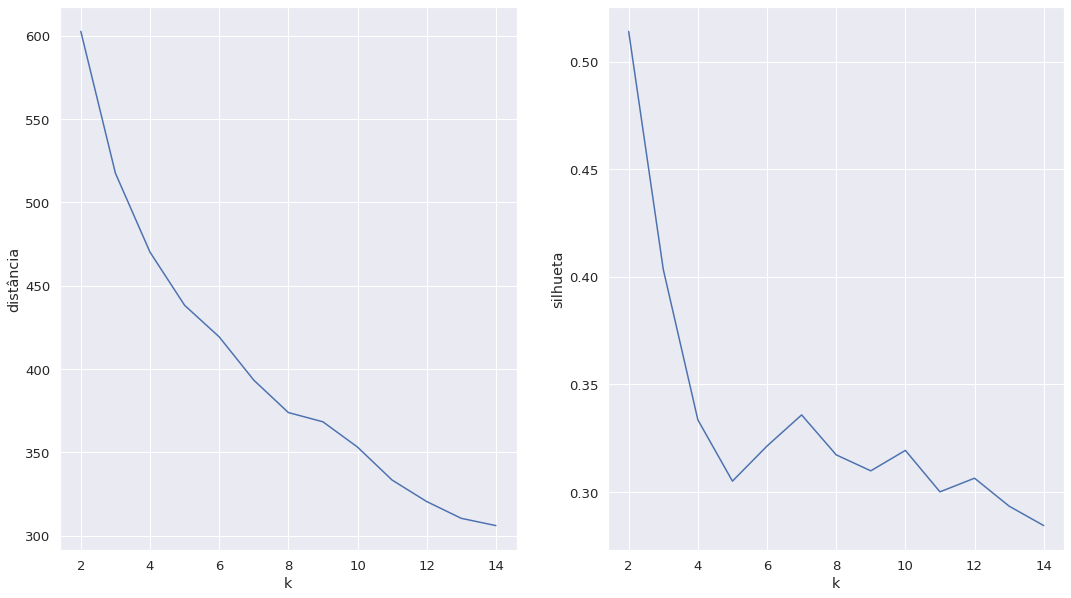

In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 2,figsize=(18,10))
ax[0].plot(n_list,dist_list)
ax[0].set_xlabel('k')
ax[0].set_ylabel('distância')
ax[1].plot(n_list,silhouette_list)
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhueta')
plt.savefig("cluster.png")

##DBSCAN##

In [8]:
from sklearn.cluster import DBSCAN

In [9]:
df_cluster = df_cluster[np.logical_not(df_cluster['idade'].isna())]
df = df[np.logical_not(df['idade'].isna())]

Normalização dos dados

In [10]:
from sklearn import preprocessing

df_cluster_n = preprocessing.minmax_scale(df_cluster, feature_range=(0,1), axis=0, copy=True)

max_list = np.max(df_cluster)
min_list = np.min(df_cluster)
for i, max in enumerate(max_list):
  df_cluster.iloc[:,i] = (df_cluster.iloc[:,i] - min_list[i])/(max - min_list[i])

In [ ]:
df[df['de_desfecho']=='O']

,Unnamed: 0,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas
0,2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",1123.0,40
1,3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",318.0,21
2,7,BB7523C235A6582C309BB3E4F8C93698,Internado,O,2,20,M,87.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",552.0,35
3,8,D831A012023DCACDE4E8B9483AD5A438,Internado,O,15,171,M,79.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",2130.0,40
4,10,F115058FEF0C6CE66E32EF72AB785F48,Internado,O,1,27,M,81.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",2481.0,37
5,11,169D64E25EC7AB52CEB15CC850D8814D,Internado,O,1,60,M,86.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",4023.0,47
6,12,BBCF1340150A86E7F6C4505EEA23F168,Internado,O,1,5,F,62.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",366.0,40
7,13,B36EE73FD954C998537979EE316F51D9,Internado,O,8,54,M,77.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Bilirrubinas Total E Fracoes,Creatinina,Fósfor...",1319.0,42
8,15,A8D97425B65357AC228B9E2015DF4E3A,Internado,O,1,112,F,87.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",3172.0,34
9,16,E7720D72394F5FAA58A9782566269412,Internado,O,1,16,M,80.0,"Desidrogenase Lática (DHL/L),Bilirrubinas Tota...","Desidrogenase Lática (DHL/L),Bilirrubinas Tota...",1256.0,34


Criação dos clusters

In [243]:
#r_list = [1.0,0.75,0.5,0.25,0.1,0.075,0.05,0.025,0.01,0.0075,0.005,0.0025,0.001,0.0001]
r_list = [1.0,0.8,0.6,0.4,0.2,0.1,0.08,0.06,0.04,0.02,0.01,0.008,0.006,0.004,0.002,0.001,0.0001]
label_list = []
labels = []
for r in r_list:
  dbscan = DBSCAN(eps=r, min_samples=150).fit(df_cluster)
  labels.append(dbscan.labels_)
  label_list.append(np.unique(dbscan.labels_))

In [244]:
df['cluster'] = dbscan.labels_

In [245]:
r_list

[1.0,
 0.8,
 0.6,
 0.4,
 0.2,
 0.1,
 0.08,
 0.06,
 0.04,
 0.02,
 0.01,
 0.008,
 0.006,
 0.004,
 0.002,
 0.001,
 0.0001]

In [246]:
len(dbscan.labels_)

4015

In [247]:
labels

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([-1,  0, -1, ...,  0,  0,  0]),
 array([-1, -1, -1, ...,  0,  0,  0]),
 array([-1, -1, -1, ...,  0,  0,  0]),
 array([-1, -1, -1, ...,  0,  0,  0]),
 array([-1, -1, -1, ...,  0,  0, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([-1, -1, -1, ..., -1, -1, -1])]

Centróides

In [248]:
label_list

[array([0]),
 array([0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1,  0]),
 array([-1]),
 array([-1]),
 array([-1]),
 array([-1]),
 array([-1]),
 array([-1]),
 array([-1])]

In [249]:

number_clusters = []
noise_list = []
for label in label_list:
    if -1 in label:
        number_clusters.append(len(label)-1)
    else:
        number_clusters.append(len(label))
for label in labels:
    if -1 in label:
        noise_list.append(len(label[label==-1]))
    else:
        noise_list.append(0)

In [250]:
noise_list

[0,
 0,
 3,
 20,
 132,
 563,
 820,
 1282,
 2166,
 3814,
 4015,
 4015,
 4015,
 4015,
 4015,
 4015,
 4015]

In [251]:
number_clusters[6]

1

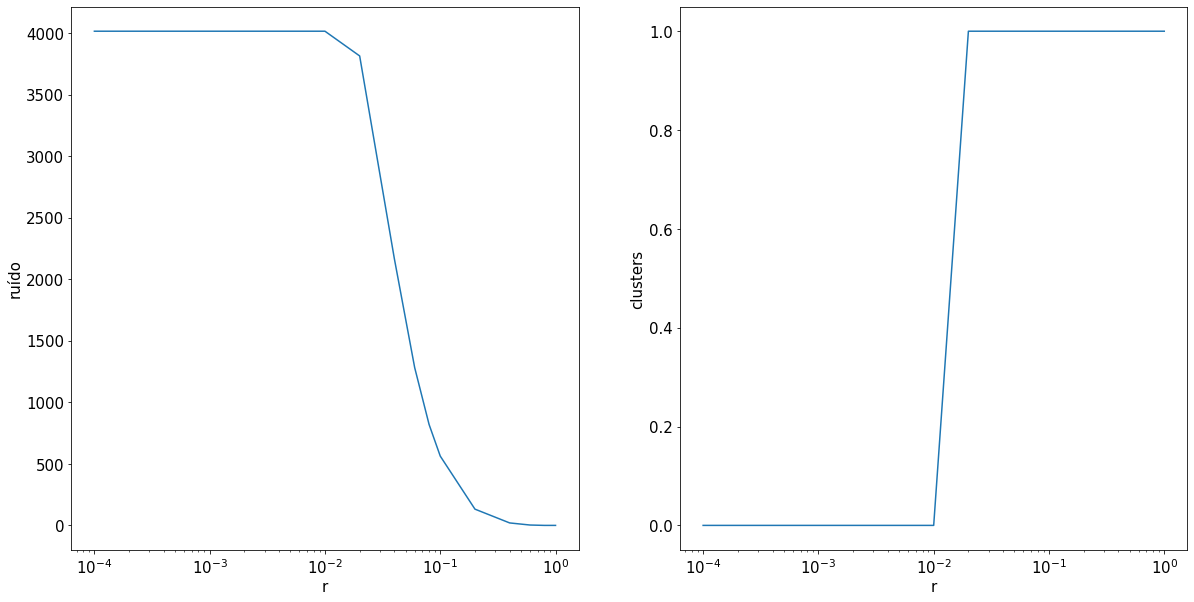

In [252]:
f, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(r_list, noise_list)
ax[0].set_xscale('log')
ax[0].set_ylabel('ruído', size = 15)
ax[0].set_xlabel('r', size = 15)
ax[0].tick_params(axis="x", labelsize=15)
ax[0].tick_params(axis="y", labelsize=15)
#ax[0].set_xlim(-1, max(depth_list) + max(depth_list) * 0.02)
#ax[0].set_ylim(0.70, 1)
#ax[0].set_ylim(min(mean_scores) - min(mean_scores) * 0.02, max(mean_scores) + max(mean_scores) * 0.02)
ax[1].plot(r_list, number_clusters)
ax[1].set_xscale('log')
ax[1].set_ylabel('clusters', size = 15)
ax[1].set_xlabel('r', size = 15)
ax[1].tick_params(axis="x", labelsize=15)
ax[1].tick_params(axis="y", labelsize=15)

plt.savefig("dbscan_150.png")

In [171]:
df['cluster'] = labels[9]

In [180]:
#df[df['cluster']==0]['n_atendimentos'].describe()
#df[df['cluster']==0]['t_atendimento'].describe()
df[df['cluster']==1]['idade'].describe()
#df[df['cluster']==1]['total_exames'].describe()
#df[df['cluster']==1]['total_problemas'].describe()

count    51.000000
mean     55.960784
std       0.773583
min      55.000000
25%      55.000000
50%      56.000000
75%      57.000000
max      57.000000
Name: idade, dtype: float64

In [59]:
df_cluster

,n_atendimentos,t_atendimento,idade,total_exames,total_problemas
0,0.013333,0.138095,0.943182,0.233070,0.639344
1,0.013333,0.057143,0.875000,0.065850,0.327869
2,0.013333,0.090476,0.977273,0.114458,0.557377
3,0.186667,0.809524,0.886364,0.442252,0.639344
4,0.000000,0.123810,0.909091,0.515164,0.590164
...,...,...,...,...,...
4010,0.000000,0.019048,1.000000,0.015372,0.098361
4011,0.013333,0.004762,0.306818,0.000000,0.000000
4012,0.053333,0.019048,0.284091,0.000208,0.000000
4013,0.066667,0.023810,0.295455,0.000000,0.000000


In [ ]:
np.unique(dbscan.labels_)

array([0])

Centróides não normalizados

In [ ]:
df['cluster'].unique()

array([-1])

In [ ]:
a

,Unnamed: 0,ID_PACIENTE,de_tipo_atendimento,de_desfecho,n_atendimentos,t_atendimento,IC_SEXO,idade,exames,problemas,total_exames,total_problemas,cluster
0,0,BA74194B979B086198794D1470107709,Internado,O,1,11,M,70.0,"Tempo E Ativid. Protrombina (Tp),Tsh - Hormoni...","Tempo E Ativid. Protrombina (Tp),Desidrogenase...",523.0,31,-1
1,2,7B03A278AD0026D4E34D0D84453A3548,Internado,O,2,30,M,84.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Acido F...",1123.0,40,-1
2,3,DE791245DF4FD631AD71B2B307F7835D,Internado,O,2,13,M,78.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",318.0,21,-1
3,4,44DA670729D76F0264E6066E2E42CF45,Internado,O,2,66,M,85.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...",3097.0,42,-1
4,5,A6567EA4CB76E002B7BEADD005279297,Internado,O,1,34,M,84.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",1431.0,27,-1
5,6,BA0E361A24C2CE6AC5582C3A0596EC16,Internado,O,9,30,M,75.0,"Urina,Tempo E Ativid. Protrombina (Tp),Hemoglo...","Urina,Tempo E Ativid. Protrombina (Tp),Hemoglo...",695.0,28,-1
6,7,BB7523C235A6582C309BB3E4F8C93698,Internado,O,2,20,M,87.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",552.0,35,-1
7,8,D831A012023DCACDE4E8B9483AD5A438,Internado,O,15,171,M,79.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...",2130.0,40,-1
8,9,21B87DA0B5E900224D034469833D5FE5,Internado,O,1,10,M,69.0,"Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",Calculo da Estimativa da Taxa de Filtracao Glo...,279.0,18,-1
9,10,F115058FEF0C6CE66E32EF72AB785F48,Internado,O,1,27,M,81.0,"Urina,Tempo E Ativid. Protrombina (Tp),Tsh - H...","Urina,Tempo E Ativid. Protrombina (Tp),Desidro...",2481.0,37,-1


#Classificação#

In [106]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

Importando a base de dados

In [107]:
df=pd.read_csv('HSL_idade.csv',sep=',')

In [108]:
df = df.drop(['de_desfecho','ID_PACIENTE','Unnamed: 0','exames','problemas'],axis=1)

In [ ]:
#df = df.drop(['IC_SEXO'],axis=1)

In [109]:
df

,de_tipo_atendimento,n_atendimentos,t_atendimento,IC_SEXO,idade,total_exames,total_problemas
0,Internado,1,11,M,70.0,523.0,31
1,Internado,2,30,M,84.0,1123.0,40
2,Internado,2,13,M,78.0,318.0,21
3,Internado,2,66,M,67.0,3097.0,42
4,Internado,1,34,M,70.0,1431.0,27
...,...,...,...,...,...,...,...
4025,Pronto Atendimento,1,5,F,89.0,75.0,7
4026,Externo,2,2,M,28.0,1.0,1
4027,Ambulatorial,5,5,F,26.0,2.0,1
4028,Pronto Atendimento,6,6,F,27.0,1.0,1


In [110]:
df['t_atendimento'].describe()

count    4030.000000
mean        9.634739
std        16.812578
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       211.000000
Name: t_atendimento, dtype: float64

In [112]:
df['t_atendimento'] = df['t_atendimento'].apply(lambda x: 0 if x <= 2 else x)
df['t_atendimento'] = df['t_atendimento'].apply(lambda x: 1 if x <= 4 and x > 2 else x)
df['t_atendimento'] = df['t_atendimento'].apply(lambda x: 2 if x <= 10 and x > 4 else x)
df['t_atendimento'] = df['t_atendimento'].apply(lambda x: 3 if x > 10 else x)

In [113]:
df['de_tipo_atendimento'].unique()
df['de_tipo_atendimento'] = df['de_tipo_atendimento'].apply(lambda x: 3 if x == 'Internado' else x)
df['de_tipo_atendimento'] = df['de_tipo_atendimento'].apply(lambda x: 2 if x == 'Pronto Atendimento' else x)
df['de_tipo_atendimento'] = df['de_tipo_atendimento'].apply(lambda x: 1 if x == 'Ambulatorial' else x)
df['de_tipo_atendimento'] = df['de_tipo_atendimento'].apply(lambda x: 0 if x == 'Externo' else x)

In [114]:
df['IC_SEXO'] = df['IC_SEXO'].apply(lambda x: 1 if x == 'M' else 0)

In [115]:
df.head()

,de_tipo_atendimento,n_atendimentos,t_atendimento,IC_SEXO,idade,total_exames,total_problemas
0,3,1,1,1,70.0,523.0,31
1,3,2,1,1,84.0,1123.0,40
2,3,2,1,1,78.0,318.0,21
3,3,2,1,1,67.0,3097.0,42
4,3,1,1,1,70.0,1431.0,27


##Árvore de decisão##

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = df.drop(['t_atendimento'],axis=1)
#y = df['t_atendimento']
y = np.array(df['t_atendimento'])

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.1, random_state=42, stratify=y)

K_VALUE = 10
seed = 7
stratifiedKfold = StratifiedKFold(n_splits=K_VALUE, random_state=seed, shuffle=True)

clf = DecisionTreeClassifier()
clf_list = []
depth_list = []

for i in range(1,101):
  clf = DecisionTreeClassifier(max_depth=i)
  clf_list.append(clf)
  depth_list.append(i)

scores_list = []
time_list = []
for clf in clf_list:
  inicio = time.time()
  scores = cross_val_score(clf, X_train, y_train, cv=stratifiedKfold)
  scores_list.append(scores)
  fim = time.time()
  time_list.append(fim - inicio)

scores_list = np.array(scores_list)
mean_scores = scores_list.mean(axis=1)

best_depth = clf_list[0].max_depth
best_score = mean_scores[0]
best_score_std = mean_scores[0].std()

for i in range(1,len(mean_scores)):
  if best_score < mean_scores[i] or (best_score == mean_scores[i] and best_score_std < mean_scores[0].std()):
    best_depth = clf_list[i].max_depth
    best_score = mean_scores[i]
    best_score_std = mean_scores[i].std()

clf = DecisionTreeClassifier(max_depth=best_depth)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
score

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14,10))

ax[0].plot(depth_list,mean_scores)
#ax[0].set_xlim(-1, max(depth_list) + max(depth_list) * 0.02)
#ax[0].set_ylim(0.70, 1)
#ax[0].set_ylim(min(mean_scores) - min(mean_scores) * 0.02, max(mean_scores) + max(mean_scores) * 0.02)
ax[1].plot(depth_list,time_list)

### Métricas, Matriz de confusão e curva roc

Acurácia, precision, recall e f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def create_pd_error_metrics(y_true, y_pred, label):
  return pd.Series({'accuracy': accuracy_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred, average='micro'),
                    'recall': recall_score(y_true, y_pred, average='micro'),
                    'f1': f1_score(y_true, y_pred, average='micro')},
                   name=label)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

pd_error_metrics = pd.concat([measure_erro(y_train, y_train_pred, 'Treinamento'),
                              measure_erro(y_test, y_test_pred, 'Teste')],
                              axis=1)

pd_error_metrics

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix

def create_conf_matrix_pd(conf_matrix):
  conf_matrix = np.array(conf_matrix)
  return pd.concat([conf_matrix_pd(conf_matrix[:,0], 'até 2 dias'),
                    conf_matrix_pd(conf_matrix[:,1], '3 ou 4 dias'),
                    conf_matrix_pd(conf_matrix[:,2], '5 a 10 dias'),
                    conf_matrix_pd(conf_matrix[:,3], 'acima de 10 dias')],
                    axis=1)

def conf_matrix_pd(conf_matrix_class_result, label):
  return pd.Series({'até 2 dias': conf_matrix_class_result[0],
                    '3 ou 4 dias': conf_matrix_class_result[1],
                    '5 a 10 dias': conf_matrix_class_result[2],
                    'acima de 10 dias':conf_matrix_class_result[3]},
                    name=label)

pd_conf_matrix = create_conf_matrix_pd(confusion_matrix(y_test, y_test_pred))

pd_conf_matrix

Curva ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#y_score = clf.decision_function(X_test)
y_score = clf.predict_proba(X_test)

y_test_binarize = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarize.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Árvore de Decisão - Max Depth = %0.0f' % clf.max_depth)
plt.legend(loc="lower right")
plt.show()

##Naive Bayes##

In [ ]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB

X = df.drop(['t_atendimento'],axis=1)
#y = df['t_atendimento']
y = np.array(df['t_atendimento'])

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.1, random_state=42, stratify=y)

K_VALUE = 10
seed = 7
stratifiedKfold = StratifiedKFold(n_splits=K_VALUE, random_state=seed, shuffle=True)

clf = GaussianNB()
clf_list = []

for i in range(1,101):
  clf = GaussianNB()
  clf_list.append(clf)

scores_list = []
time_list = []
for clf in clf_list:
  inicio = time.time()
  scores = cross_val_score(clf, X, y, cv=stratifiedKfold)
  scores_list.append(scores)
  fim = time.time()
  time_list.append(fim - inicio)

scores_list = np.array(scores_list)
mean_scores = scores_list.mean(axis=1)

clf = GaussianNB()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
score

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14,10))

ax[0].plot(depth_list,mean_scores)
#ax[0].set_xlim(-1, max(depth_list) + max(depth_list) * 0.02)
#ax[0].set_ylim(0.70, 1)
#ax[0].set_ylim(min(mean_scores) - min(mean_scores) * 0.02, max(mean_scores) + max(mean_scores) * 0.02)
ax[1].plot(depth_list,time_list)

### Métricas, Matriz de confusão e curva roc

Acurácia, precision, recall e f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def create_pd_error_metrics(y_true, y_pred, label):
  return pd.Series({'accuracy': accuracy_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred, average='micro'),
                    'recall': recall_score(y_true, y_pred, average='micro'),
                    'f1': f1_score(y_true, y_pred, average='micro')},
                   name=label)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

pd_error_metrics = pd.concat([measure_erro(y_train, y_train_pred, 'Treinamento'),
                              measure_erro(y_test, y_test_pred, 'Teste')],
                              axis=1)

pd_error_metrics

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix

def create_conf_matrix_pd(conf_matrix):
  conf_matrix = np.array(conf_matrix)
  return pd.concat([conf_matrix_pd(conf_matrix[:,0], 'até 2 dias'),
                    conf_matrix_pd(conf_matrix[:,1], '3 ou 4 dias'),
                    conf_matrix_pd(conf_matrix[:,2], '5 a 10 dias'),
                    conf_matrix_pd(conf_matrix[:,3], 'acima de 10 dias')],
                    axis=1)

def conf_matrix_pd(conf_matrix_class_result, label):
  return pd.Series({'até 2 dias': conf_matrix_class_result[0],
                    '3 ou 4 dias': conf_matrix_class_result[1],
                    '5 a 10 dias': conf_matrix_class_result[2],
                    'acima de 10 dias':conf_matrix_class_result[3]},
                    name=label)

pd_conf_matrix = create_conf_matrix_pd(confusion_matrix(y_test, y_test_pred))

pd_conf_matrix

Curva ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#y_score = clf.decision_function(X_test)
y_score = clf.predict_proba(X_test)

y_test_binarize = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarize.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Naive Bayes - Modificar Depois %0.0f' % 0)
plt.legend(loc="lower right")
plt.show()

##kNN##

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import preprocessing

X = df.drop(['t_atendimento'],axis=1)
#y = df['t_atendimento']
y = np.array(df['t_atendimento'])

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.1, random_state=42, stratify=y)

K_VALUE = 10
seed = 7
stratifiedKfold = StratifiedKFold(n_splits=K_VALUE, random_state=seed, shuffle=True)

clf_list = []
k_list = []

for i in range(1,15):
  clf = clf = KNeighborsClassifier(n_neighbors=i)
  clf_list.append(clf)
  k_list.append(i)

scores_list = []
time_list = []
for clf in clf_list:
  inicio = time.time()
  scores = cross_val_score(clf, X_train, y_train, cv=stratifiedKfold)
  scores_list.append(scores)
  fim = time.time()
  time_list.append(fim - inicio)

best_k = clf_list[0].n_neighbors
best_score = mean_scores[0]
best_score_std = mean_scores[0].std()

for i in range(1,len(mean_scores)):
  if best_score < mean_scores[i] or (best_score == mean_scores[i] and best_score_std < mean_scores[0].std()):
    best_k = clf_list[i].n_neighbors
    best_score = mean_scores[i]
    best_score_std = mean_scores[i].std()

scores_list = np.array(scores_list)
mean_scores = scores_list.mean(axis=1)

clf = KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
score

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14,10))

ax[0].plot(k_list,mean_scores)
#ax[0].set_xlim(-1, max(k_list) + max(k_list) * 0.02)
#ax[0].set_ylim(0.70, 1)
#ax[0].set_ylim(min(mean_scores) - min(mean_scores) * 0.02, max(mean_scores) + max(mean_scores) * 0.02)
ax[1].plot(k_list,time_list)

### Métricas, Matriz de confusão e curva roc

Acurácia, precision, recall e f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def create_pd_error_metrics(y_true, y_pred, label):
  return pd.Series({'accuracy': accuracy_score(y_true, y_pred),
                    'precision': precision_score(y_true, y_pred, average='micro'),
                    'recall': recall_score(y_true, y_pred, average='micro'),
                    'f1': f1_score(y_true, y_pred, average='micro')},
                   name=label)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

pd_error_metrics = pd.concat([measure_erro(y_train, y_train_pred, 'Treinamento'),
                              measure_erro(y_test, y_test_pred, 'Teste')],
                              axis=1)

pd_error_metrics

Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix

def create_conf_matrix_pd(conf_matrix):
  conf_matrix = np.array(conf_matrix)
  return pd.concat([conf_matrix_pd(conf_matrix[:,0], 'até 2 dias'),
                    conf_matrix_pd(conf_matrix[:,1], '3 ou 4 dias'),
                    conf_matrix_pd(conf_matrix[:,2], '5 a 10 dias'),
                    conf_matrix_pd(conf_matrix[:,3], 'acima de 10 dias')],
                    axis=1)

def conf_matrix_pd(conf_matrix_class_result, label):
  return pd.Series({'até 2 dias': conf_matrix_class_result[0],
                    '3 ou 4 dias': conf_matrix_class_result[1],
                    '5 a 10 dias': conf_matrix_class_result[2],
                    'acima de 10 dias':conf_matrix_class_result[3]},
                    name=label)

pd_conf_matrix = create_conf_matrix_pd(confusion_matrix(y_test, y_test_pred))

pd_conf_matrix

Curva ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#y_score = clf.decision_function(X_test)
y_score = clf.predict_proba(X_test)

y_test_binarize = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_binarize.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarize.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - KNN - K = %0.0f' % clf.n_neighbors)
plt.legend(loc="lower right")
plt.show()

##Auto Learner##

### Install

In [ ]:
!apt-get install swig -y
!pip install Cython numpy

# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn

In [ ]:
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip3 install
!pip3 install auto-sklearn

In [ ]:
!pip install auto-sklearn -U
!pip install Cython -U
!pip install numpy -U

### Use Auto Learn

In [155]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

X = df.drop(['t_atendimento'],axis=1)
#y = df['t_atendimento']
y = np.array(df['t_atendimento'])

!rm -rf '/content/autosklearn_tmp_result'

X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)

automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=5*60, #segundos
          #per_run_time_limit=30, #Parece ser o tempo máximo para uma chamada de machine learning, se passar desse tempo ele abrota e parte pra outra.
          tmp_folder= '/content/autosklearn_tmp_result/autosklearn_classification_example_tmp',
          output_folder='/content/autosklearn_tmp_result/autosklearn_classification_example_out',
          n_jobs= 8, # não sei se o collab suporta 8, mas aqui colcoariamos quantos jobs o PC suporta
          #ensemble_size=1, initial_configurations_via_metalearning=0 #Usar esses parâmetros se quisermos que o autolearning use apenas 1 classificador.
          ) 

    
automl.fit(X_train, y_train, dataset_name="HSL Idade")
y_hat = automl.predict(X_test)

/usr/local/lib/python3.6/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38971 instead
  http_address["port"], self.http_server.port


[WARNING] [2020-11-23 19:23:54,993:AutoML(1):HSL Idade] Capping the per_run_time_limit to 59.0 to have time for a least 2 models in each process.


In [156]:
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))

Accuracy score 0.9057539682539683


In [157]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: HSL Idade
  Metric: accuracy
  Best validation score: 0.907816
  Number of target algorithm runs: 17
  Number of successful target algorithm runs: 16
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



In [176]:
print(automl.show_models())

[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_tran

In [190]:
automl.get_models_with_weights()

[(1.0,
  SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transfo

In [192]:
print(len(automl.automl_.runhistory_.data))
print(len(automl.get_models_with_weights()))

17
1


In [193]:
def create_conf_matrix_pd(conf_matrix, model_name):
  conf_matrix = np.array(conf_matrix)
  return pd.concat([conf_matrix_pd(conf_matrix[:,0], model_name),
                    conf_matrix_pd(conf_matrix[:,1], model_name),
                    conf_matrix_pd(conf_matrix[:,2], model_name),
                    conf_matrix_pd(conf_matrix[:,3], model_name)],
                    axis=1)

def conf_matrix_pd(conf_matrix_class_result, label):
  return pd.Series({'Acurácia': conf_matrix_class_result[0],
                    'Tempo de Treinamento': conf_matrix_class_result[1],
                    '5 a 10 dias': conf_matrix_class_result[2],
                    'acima de 10 dias':conf_matrix_class_result[3]},
                    name=label)

model_count = len(automl.get_models_with_weights()

params
for i in range(0, model_count):



print(len(automl.cv_results_['mean_test_score']))

[(1.0,
  SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:categorical_transfo

####  Outras informações importantes

In [ ]:
for run_key in automl.automl_.runhistory_.data:
    print('#########')
    print("Run Key")
    print("  Configuration ID:", run_key.config_id)
    print("  Instance:", run_key.instance_id)
    print("  Seed:", run_key.seed)
    print("  Budget:", run_key.budget)
    run_value = automl.automl_.runhistory_.data[run_key]
    print("Run Value")
    print("  Cost:", run_value.cost)
    print("  Time:", run_value.time)
    print("  Status:", run_value.status)
    print("  Additional information:", run_value.additional_info)
    print("  Start time:", run_value.starttime)
    print("  End time", run_value.endtime)
    print(automl.automl_.runhistory_.ids_config[run_key.config_id])

In [ ]:
 losses_and_configurations = [
    (run_value.cost, run_key.config_id)
    for run_key, run_value in automl.automl_.runhistory_.data.items()
]
losses_and_configurations.sort()
print("Lowest loss:", losses_and_configurations[0][0])
print(
    "Best configuration:",
    automl.automl_.runhistory_.ids_config[losses_and_configurations[0][1]]
)

print(
    "Second Best configuration:",
    automl.automl_.runhistory_.ids_config[losses_and_configurations[1][1]]
)

In [210]:
automl.automl_.runhistory_.ids_config[losses_and_configurations[0][1]]


Configuration:
  balancing:strategy, Value: 'none'
  classifier:__choice__, Value: 'random_forest'
  classifier:random_forest:bootstrap, Value: 'True'
  classifier:random_forest:criterion, Value: 'gini'
  classifier:random_forest:max_depth, Constant: 'None'
  classifier:random_forest:max_features, Value: 0.5
  classifier:random_forest:max_leaf_nodes, Constant: 'None'
  classifier:random_forest:min_impurity_decrease, Constant: 0.0
  classifier:random_forest:min_samples_leaf, Value: 1
  classifier:random_forest:min_samples_split, Value: 2
  classifier:random_forest:min_weight_fraction_leaf, Constant: 0.0
  data_preprocessing:categorical_transformer:categorical_encoding:__choice__, Value: 'one_hot_encoding'
  data_preprocessing:categorical_transformer:category_coalescence:__choice__, Value: 'minority_coalescer'
  data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction, Value: 0.01
  data_preprocessing:numerical_transformer:imputation:strategy, V

In [ ]:
losses_and_configurations

In [195]:
print(len(automl.cv_results_['mean_test_score']))

print(automl.cv_results_)

17
{'mean_test_score': array([0.90781563, 0.85771543, 0.85671343, 0.8507014 , 0.8747495 ,
       0.81863727, 0.81963928, 0.88376754, 0.8246493 , 0.63226453,
       0.85871743, 0.61523046, 0.67935872, 0.90280561, 0.84769539,
       0.86673347, 0.        ]), 'mean_fit_time': array([33.19072676, 14.6823132 , 37.17400956, 27.36511493, 16.52602124,
       15.2402246 , 32.03987384, 29.99838948, 25.88125873, 13.1432333 ,
        6.14832616,  5.85154462,  6.24873614,  6.45644546, 10.23396134,
        7.1605556 , 11.79589248]), 'params': [{'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'standardize', 'feature_preprocessor:__choice__': 'no_pr